In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [2]:
path_sn = "data_files/sn_data.txt"
path_kp = "data_files/kp_data.txt"

data_sn = pd.read_csv(path_sn)
data_kp = pd.read_csv(path_kp)
data_sn["date"] = pd.to_datetime(data_sn["date"])
data_kp["datetime"] = pd.to_datetime(data_kp["datetime"])
data_kp["date"] = data_kp["datetime"].dt.floor("d")
data_kp = data_kp.drop(columns=["datetime"])
data_kp = data_kp.groupby(data_kp["date"]).max().reset_index()
data_merged = data_kp.merge(data_sn)
data_merged_arr = data_merged.loc[:, ["SN", "Kp"]].values

In [3]:
data_merged_arr[int(len(data_merged_arr) * 0.7):][:, 1]

array([2.   , 2.   , 1.667, ..., 3.   , 2.333, 2.667])

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = data_merged_arr#scaler.fit_transform(data_merged_arr)

In [5]:
def create_dataset(data_arr, lookback):
    X, y = [], []
    for i in range(len(data_arr)-lookback):
        feature = data_arr[i:i+lookback]
        target = data_arr[i+1:i+lookback+1, 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)


In [6]:
lookback = 7
train_frac = 0.7
train_size = int(len(data_scaled) * train_frac)
train = data_scaled[:train_size]
test = data_scaled[train_size:]

In [7]:
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([3574, 7, 2]) torch.Size([3574, 7, 1])
torch.Size([1528, 7, 2]) torch.Size([1528, 7, 1])


In [8]:
test[1:8]

array([[0.   , 2.   ],
       [0.   , 1.667],
       [0.   , 2.667],
       [0.   , 2.667],
       [0.   , 1.   ],
       [0.   , 1.667],
       [0.   , 2.   ]])

In [9]:
X_test[0][:, 1]

tensor([2.0000, 2.0000, 1.6670, 2.6670, 2.6670, 1.0000, 1.6670])

In [10]:
y_test[0]

tensor([[2.0000],
        [1.6670],
        [2.6670],
        [2.6670],
        [1.0000],
        [1.6670],
        [2.0000]])

In [11]:
class SunModelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(SunModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
input_size = 2
hidden_size = 50
num_layers = 5
batch_size = 32

In [13]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [14]:
def train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device):
    train_hist = []
    test_hist = []

    # Training loop
    for epoch in range(n_epochs):
        total_loss = 0.0
    
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        # Calculate average training loss and accuracy
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)
    
        # Validation on test data
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
    
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)
    
                total_test_loss += test_loss.item()
    
            # Calculate average test loss and accuracy
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
        if (epoch+1)%10==0:
            print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    return train_hist, test_hist    

In [15]:
n_epochs = 50
loss_fn = nn.MSELoss(reduction='mean')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SunModelLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

/home/ali/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


SunModelLSTM(
  (lstm): LSTM(2, 50, num_layers=5, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [16]:
train_hist, test_hist = train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device)

Epoch [10/50] - Training Loss: 1.7958, Test Loss: 1.7985
Epoch [20/50] - Training Loss: 1.7435, Test Loss: 1.7597
Epoch [30/50] - Training Loss: 1.7430, Test Loss: 1.7590
Epoch [40/50] - Training Loss: 1.7399, Test Loss: 1.7557
Epoch [50/50] - Training Loss: 1.2991, Test Loss: 1.3567


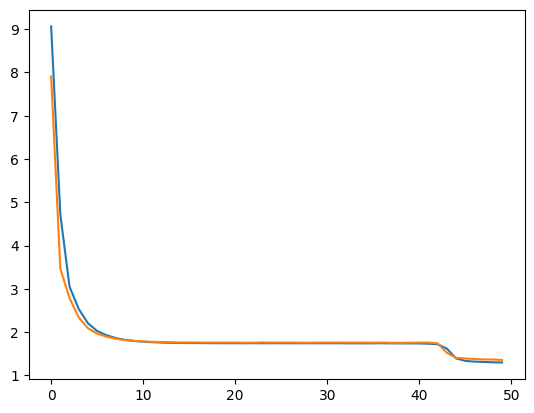

In [17]:
plt.plot(train_hist)
plt.plot(test_hist)

In [18]:
def make_pred1(X_test, num_forecast_steps):
    sequence_to_plot = X_test.squeeze().cpu().numpy()
    historical_data = sequence_to_plot[0]
    forecasted_values = []
    with torch.no_grad():
        for _ in range(num_forecast_steps+7):
            historical_data_tensor = torch.as_tensor(historical_data).float().to(device)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0]
            forecasted_values.append(predicted_value[0])

            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value
    return forecasted_values

In [19]:
num_forecast_steps = 28
forecasted_vals = make_pred1(X_test, num_forecast_steps)
# forecasted_vals = scaler.inverse_transform(np.stack((np.arange(len(forecasted_vals)), forecasted_vals)).T)[:, 1]
true_data = test[0:num_forecast_steps + 7]
# true_data = scaler.inverse_transform(true_data)[:, 1]

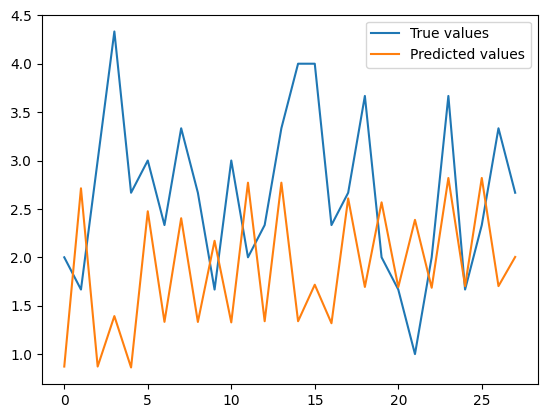

In [20]:
# plt.plot(final_ytest, label="True values")
plt.plot(true_data[7:, 1], label="True values")
plt.plot(forecasted_vals[7:], label="Predicted values")
# plt.ylim(0, 3)
plt.legend()
